In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import joblib
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# настройки TensorFlow для воспроизводимости
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# проверка доступности GPU
print("Доступные устройства:")
for device in tf.config.list_physical_devices():
    print(f"{device.device_type}: {device.name}")

Доступные устройства:
CPU: /physical_device:CPU:0
GPU: /physical_device:GPU:0


In [ ]:
data = np.load('processed_gesture_data.npz', allow_pickle=True)

In [ ]:
# временные окна
X_train_cnn = data['X_train']
y_train_cnn = data['y_train']
X_val_cnn = data['X_val']
y_val_cnn = data['y_val']
X_test_cnn = data['X_test']
y_test_cnn = data['y_test']

In [ ]:
with open('gesture_metadata.json', 'r') as f:
    metadata = json.load(f)

In [ ]:
print(f"Размеры данных:")
print(f"X_train: {X_train_cnn.shape}")
print(f"X_val:   {X_val_cnn.shape}")

Размеры данных:
X_train: (1468, 60, 3)
X_val:   (179, 60, 3)


In [ ]:
WINDOW_SIZE = metadata['window_size']
N_FEATURES = X_train_cnn.shape[2]
N_CLASSES = len(metadata['gesture_names'])

print(f"\nПараметры:")
print(f"Размер окна: {WINDOW_SIZE}")
print(f"Количество признаков: {N_FEATURES}")
print(f"Количество классов: {N_CLASSES}")


Параметры:
Размер окна: 60
Количество признаков: 3
Количество классов: 6


## Подготовка данных

In [ ]:
# one-hot encoding
y_train_cat = keras.utils.to_categorical(y_train_cnn, N_CLASSES)
y_val_cat = keras.utils.to_categorical(y_val_cnn, N_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test_cnn, N_CLASSES)

In [ ]:
print(f"y_train_cat: {y_train_cat.shape}")
print(f"y_test_cat:  {y_test_cat.shape}")

y_train_cat: (1468, 6)
y_test_cat:  (180, 6)


In [ ]:
def plot_training_history(history, title):
    """Функция для визуализации процесса обучения"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # график точности
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # график потерь
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def build_1d_cnn(input_shape, num_classes, dropout_rate=0.3, l2_reg=0.001):
    """Построение модели 1D CNN"""
    model = models.Sequential([
        # входной слой
        layers.Input(shape=input_shape),

        # первый сверточный блок
        layers.Conv1D(filters=16, kernel_size=3, padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(dropout_rate),

        # второй сверточный блок
        layers.Conv1D(filters=32, kernel_size=3, padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(dropout_rate),

        # третий сверточный блок
        layers.Conv1D(filters=64, kernel_size=3, padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(dropout_rate),

        # полносвязные слои
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate * 0.5),

        # выходной слой
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
# построение модели
cnn_model = build_1d_cnn(
    input_shape=(WINDOW_SIZE, N_FEATURES),
    num_classes=N_CLASSES,
    dropout_rate=0.3,
    l2_reg=0.001
)

In [ ]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# подсчет параметров модели
total_params = cnn_model.count_params()
print(f"\nВсего параметров: {total_params:,}")
print(f"Ориентировочный размер модели: {(total_params * 4) / 1024:.2f} KB")


Всего параметров: 10,790
Ориентировочный размер модели: 42.15 KB


In [ ]:
# callbacks
cnn_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=0.00001,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# обучение
cnn_history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=cnn_callbacks,
    verbose=1
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2291 - loss: 2.1332
Epoch 1: val_accuracy improved from -inf to 0.35754, saving model to best_cnn_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.2298 - loss: 2.1305 - val_accuracy: 0.3575 - val_loss: 1.8231 - learning_rate: 0.0010
Epoch 2/100
35/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3710 - loss: 1.7827
Epoch 2: val_accuracy did not improve from 0.35754
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3800 - loss: 1.7557 - val_accuracy: 0.3408 - val_loss: 1.7163 - learning_rate: 0.0010
Epoch 3/100
36/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4561 - loss: 1.5267
Epoch 3: val_accuracy did not improve from 0.35754
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4627 - loss: 1.5118 - val_accuracy: 0.2849 - val_loss: 1.6812 - learning_rate: 0.0010
Epoch 4/100
34/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4779 - loss: 1.3859
Epoch 4: val_accuracy did not improve from 0.35

In [ ]:
# оценка
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Точность 1D CNN на тестовых данных: {cnn_test_acc:.4f}")

Точность 1D CNN на тестовых данных: 0.7611


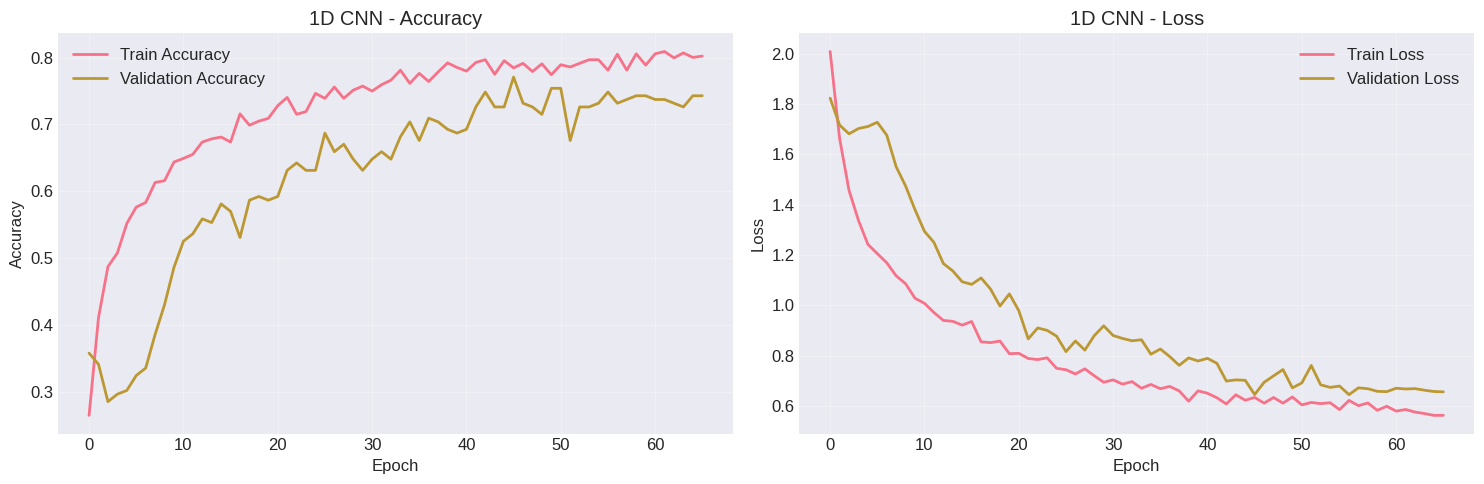

In [ ]:
# визуализация обучения
plot_training_history(cnn_history, "1D CNN")

## Статистика

In [ ]:
best_cnn_model = keras.models.load_model('best_cnn_model.keras')

In [ ]:
# предсказания на тестовых данных
y_pred_proba = best_cnn_model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=metadata['gesture_names'].values()))


Classification Report:
                                     precision    recall  f1-score   support

               idle (неподвижность)       0.67      0.53      0.59        30
                   up (взмах вверх)       0.79      0.87      0.83        30
                  down (взмах вниз)       0.88      0.93      0.90        30
circle_cw (круг по часовой стрелке)       0.70      0.93      0.80        30
                shake (стряхивание)       0.94      0.53      0.68        30
                 tap (постукивание)       0.68      0.77      0.72        30

                           accuracy                           0.76       180
                          macro avg       0.77      0.76      0.75       180
                       weighted avg       0.77      0.76      0.75       180



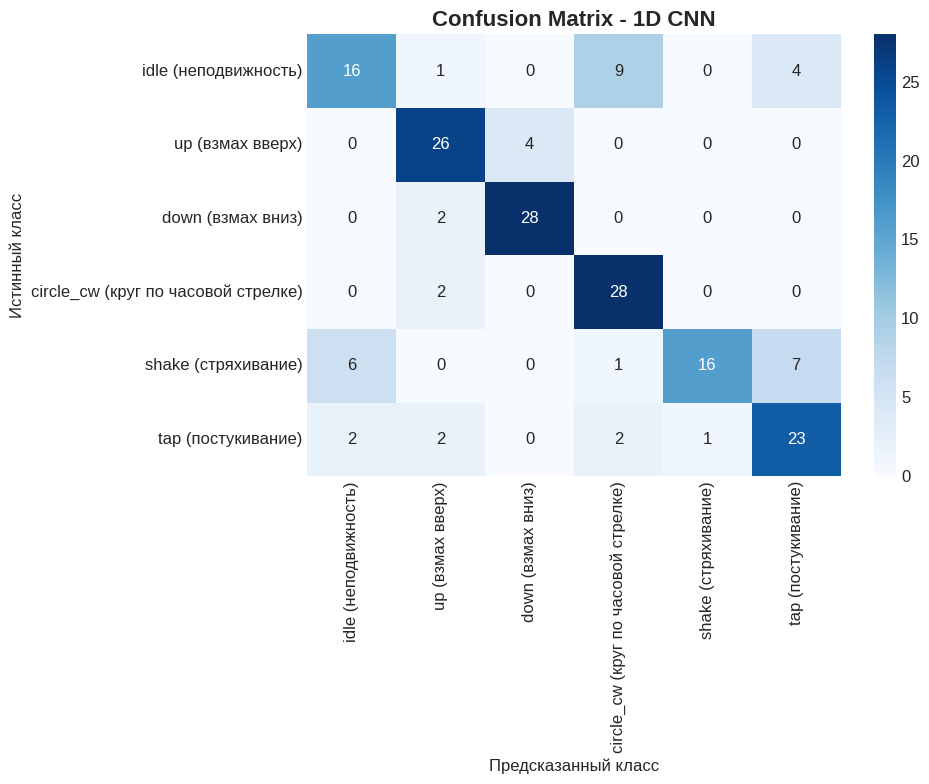

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=metadata['gesture_names'].values(),
            yticklabels=metadata['gesture_names'].values())
plt.title('Confusion Matrix - 1D CNN', fontsize=16, fontweight='bold')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

In [ ]:
# precision, recall, f1 для каждого класса
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

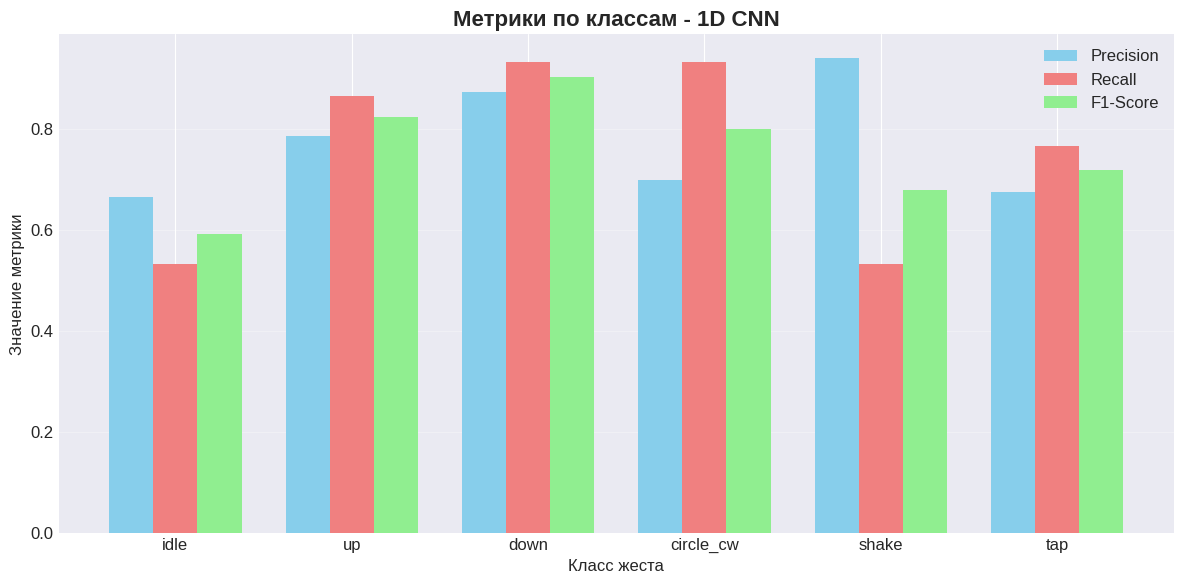

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metadata['gesture_names']))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
bars2 = ax.bar(x, recall, width, label='Recall', color='lightcoral')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='lightgreen')

ax.set_title('Метрики по классам - 1D CNN', fontsize=16, fontweight='bold')
ax.set_xlabel('Класс жеста')
ax.set_ylabel('Значение метрики')
ax.set_xticks(x)
ax.set_xticklabels([metadata['gesture_names'][str(i)].split()[0] for i in range(N_CLASSES)])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Оптимизация и квантование

In [ ]:
def build_optimized_cnn(input_shape, num_classes):
    """Создание оптимизированной модели для Arduino"""
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # упрощенный сверточный блок
        layers.Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        # второй сверточный блок
        layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.2),

        # полносвязные слои
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
optimized_cnn = build_optimized_cnn(
    input_shape=(WINDOW_SIZE, N_FEATURES),
    num_classes=N_CLASSES
)

In [ ]:
optimized_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# обучение
optimized_history = optimized_cnn.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
    ]
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6635 - loss: 0.8325 - val_accuracy: 0.6648 - val_loss: 0.7871
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6640 - loss: 0.8301 - val_accuracy: 0.6592 - val_loss: 0.7754
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6520 - loss: 0.8391 - val_accuracy: 0.6592 - val_loss: 0.7822
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6329 - loss: 0.8552 - val_accuracy: 0.6648 - val_loss: 0.7753
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6725 - loss: 0.8285 - val_accuracy: 0.6704 - val_loss: 0.7686
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6426 - loss: 0.8664 - val_accuracy: 0.6872 - val_loss: 0.7676
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6477 - loss: 0.8605 - val_accuracy: 0.6648 - val_loss: 0.7670
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6609 - loss: 0.8456 - val_accuracy: 0.6648 -

In [ ]:
# оценка
opt_test_loss, opt_test_acc = optimized_cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Точность оптимизированной CNN: {opt_test_acc:.4f}")

Точность оптимизированной CNN: 0.7722


In [ ]:
optimized_cnn.save('optimized_cnn_model.h5')

In [ ]:
def quantize_model(model_path, representative_data):
    """Квантование модели для TinyML"""
    converter = tf.lite.TFLiteConverter.from_keras_model(model_path)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    # калибровочный датасет для квантования
    def representative_dataset():
        for i in range(100):
            yield [representative_data[i].reshape(1, WINDOW_SIZE, N_FEATURES).astype(np.float32)]

    converter.representative_dataset = representative_dataset

    # конвертация
    tflite_model = converter.convert()

    return tflite_model

In [ ]:
# подготовка представительных данных
representative_samples = X_train_cnn[:100]

In [ ]:
# квантование модели
try:
    tflite_quantized_model = quantize_model(optimized_cnn, representative_samples)

    # сохраняем квантованную модель
    with open('gesture_model_quantized.tflite', 'wb') as f:
        f.write(tflite_quantized_model)

    model_size_kb = len(tflite_quantized_model) / 1024
    print(f"Размер квантованной модели: {model_size_kb:.2f} KB")

    flash_available = 32
    ram_available = 2

    if model_size_kb < flash_available * 0.8:
        print(f"Модель поместится в память Arduino")
    else:
        print(f"Модель не поместится в память Arduino")

except Exception as e:
    print(f"Ошибка при квантовании: {e}")
    converter = tf.lite.TFLiteConverter.from_keras_model(optimized_cnn)
    tflite_model = converter.convert()
    with open('gesture_model.tflite', 'wb') as f:
        f.write(tflite_model)

    print(f"Размер неквантованной модели: {len(tflite_model) / 1024:.2f} KB")

Saved artifact at '/tmp/tmp1jov1p7u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 3), dtype=tf.float32, name='keras_tensor_460')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134441445643792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134441445641104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134441445642832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134441445646672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134441445643024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134441445639568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134441445643216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134441445645904: TensorSpec(shape=(), dtype=tf.resource, name=None)
Размер квантованной модели: 7.49 KB
Модель поместится в память Arduino


In [ ]:
def convert_to_c_array(model_path, array_name='model_tflite'):
    """Конвертирует .tflite файл в C массив"""
    try:
        import subprocess
        import os

        if not os.path.exists(model_path):
            model_path = 'gesture_model.tflite'

        cmd = f"xxd -i {model_path}"
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

        if result.returncode == 0:
            c_code = result.stdout

            c_code = c_code.replace(model_path.replace('.', '_'), 'gesture_model')

            with open('gesture_model.h', 'w') as f:
                f.write(c_code)

            lines = c_code.split('\n')
            for line in lines:
                if 'unsigned int' in line and 'gesture_model_len' in line:
                    size_kb = int(line.split('=')[1].replace(';', '').strip()) / 1024
                    print(f"Размер массива: {size_kb:.2f} KB")
        else:
            print(f"Ошибка конвертации: {result.stderr}")

            # альтернативный способ: читаем бинарный файл и создаем массив вручную
            with open(model_path, 'rb') as f:
                model_bytes = f.read()

            with open('gesture_model.h', 'w') as f:
                f.write(f'const unsigned char gesture_model[] = {{\n')
                for i, byte in enumerate(model_bytes):
                    f.write(f'0x{byte:02x}, ')
                    if (i + 1) % 12 == 0:
                        f.write('\n')
                f.write('\n};\n')
                f.write(f'const unsigned int gesture_model_len = {len(model_bytes)};\n')

            print(f"Модель сконвертирована альтернативным способом")
            print(f"Размер массива: {len(model_bytes) / 1024:.2f} KB")

    except Exception as e:
        print(f"Ошибка: {e}")

In [ ]:
# конвертируем модель
convert_to_c_array('gesture_model_quantized.tflite')

Размер массива: 7.49 KB


## Тестирование

In [ ]:
interpreter = tf.lite.Interpreter(model_path='gesture_model_quantized.tflite')
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
print("Информация о TFLite модели:")
print(f"Входной тензор: {input_details[0]['shape']}")
print(f"Выходной тензор: {output_details[0]['shape']}")
print(f"Тип входных данных: {input_details[0]['dtype']}")
print(f"Тип выходных данных: {output_details[0]['dtype']}")

Информация о TFLite модели:
Входной тензор: [ 1 60  3]
Выходной тензор: [1 6]
Тип входных данных: <class 'numpy.int8'>
Тип выходных данных: <class 'numpy.int8'>


In [ ]:
# Тестирование на нескольких примерах
test_indices = np.random.choice(len(X_test_cnn), 10, replace=False)

In [ ]:
correct = 0
for idx in test_indices:
    test_sample = X_test_cnn[idx].astype(np.float32)
    true_label = y_true[idx]

    if input_details[0]['dtype'] == np.int8:
        # квантуем входные данные
        input_scale, input_zero_point = input_details[0]['quantization']
        test_sample_quantized = test_sample / input_scale + input_zero_point
        test_sample_quantized = test_sample_quantized.astype(np.int8)
        interpreter.set_tensor(input_details[0]['index'], test_sample_quantized.reshape(1, WINDOW_SIZE, N_FEATURES))
    else:
        interpreter.set_tensor(input_details[0]['index'], test_sample.reshape(1, WINDOW_SIZE, N_FEATURES))

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred_label = np.argmax(output_data)

    if output_details[0]['dtype'] == np.int8:
        output_scale, output_zero_point = output_details[0]['quantization']
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

    if pred_label == true_label:
        correct += 1

    gesture_name_true = metadata['gesture_names'][str(true_label)].split()[0]
    gesture_name_pred = metadata['gesture_names'][str(pred_label)].split()[0]

    print(f"  Пример {idx}: Истинный={gesture_name_true}, Предсказанный={gesture_name_pred}, "
          f"Уверенность={output_data.max():.2f} {'OK' if pred_label == true_label else 'NOT OK'}")

  Пример 19: Истинный=circle_cw, Предсказанный=circle_cw, Уверенность=0.89 OK
  Пример 42: Истинный=down, Предсказанный=down, Уверенность=0.73 OK
  Пример 153: Истинный=idle, Предсказанный=idle, Уверенность=0.55 OK
  Пример 78: Истинный=shake, Предсказанный=idle, Уверенность=0.50 NOT OK
  Пример 145: Истинный=circle_cw, Предсказанный=up, Уверенность=0.75 NOT OK
  Пример 15: Истинный=tap, Предсказанный=tap, Уверенность=0.57 OK
  Пример 24: Истинный=circle_cw, Предсказанный=circle_cw, Уверенность=0.72 OK
  Пример 68: Истинный=tap, Предсказанный=shake, Уверенность=0.52 NOT OK
  Пример 113: Истинный=tap, Предсказанный=shake, Уверенность=0.42 NOT OK
  Пример 118: Истинный=down, Предсказанный=down, Уверенность=0.75 OK


In [ ]:
print(f"\nТочность TFLite модели на 10 примерах: {correct}/10 ({correct/10*100:.1f}%)")


Точность TFLite модели на 10 примерах: 6/10 (60.0%)


## Сохранение результатов

In [ ]:
final_results = {
    'best_model': '1D_CNN',
    'accuracy': float(cnn_test_acc),
    'optimized_accuracy': float(opt_test_acc),
    'model_size_kb': model_size_kb if 'model_size_kb' in locals() else len(tflite_model) / 1024,
    'window_size': WINDOW_SIZE,
    'n_features': N_FEATURES,
    'n_classes': N_CLASSES,
    'training_history': {
        'cnn_val_accuracy': cnn_history.history['val_accuracy'],
        'cnn_val_loss': cnn_history.history['val_loss'],
        'cnn_train_accuracy': cnn_history.history['accuracy'],
        'cnn_train_loss': cnn_history.history['loss']
    }
}

In [ ]:
with open('training_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

In [ ]:
print("Сохраненные файлы:")
print("1. gesture_model.h - C-массив модели для Arduino")
print("2. gesture_model_quantized.tflite - квантованная TFLite модель")
print("3. optimized_cnn_model.h5 - оптимизированная Keras модель")
print("4. training_results.json - результаты обучения")
print("5. best_cnn_model.keras - лучшая версия CNN модели")

Сохраненные файлы:
1. gesture_model.h - C-массив модели для Arduino
2. gesture_model_quantized.tflite - квантованная TFLite модель
3. optimized_cnn_model.h5 - оптимизированная Keras модель
4. training_results.json - результаты обучения
5. best_cnn_model.keras - лучшая версия CNN модели


In [ ]:
print(f"Точность на тестовых данных: {cnn_test_acc:.4f} ({cnn_test_acc*100:.1f}%)")
print(f"Точность оптимизированной модели: {opt_test_acc:.4f} ({opt_test_acc*100:.1f}%)")
print(f"Размер квантованной модели: {final_results['model_size_kb']:.2f} KB")

Точность на тестовых данных: 0.7611 (76.1%)
Точность оптимизированной модели: 0.7722 (77.2%)
Размер квантованной модели: 7.49 KB
